# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 81216891.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

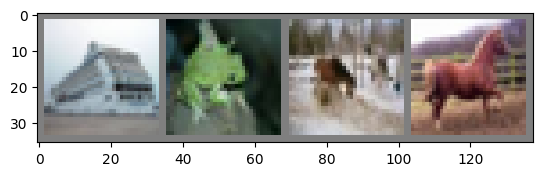

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32)
        )
        self.model2 = nn.Sequential(
             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        )

        self.model3 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.model3(self.model1(x) + self.model2(x))

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (model1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model2): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (model3): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:

net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    loss_function = nn.CrossEntropyLoss()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)

        loss = loss_function(output, target)
        loss_log.append(loss.item())
        
        acc = (output.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    loss_function = nn.CrossEntropyLoss()
    for data, target in train_loader:
        
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        loss_log.append(loss.item())
        
        acc = (output.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item()) 
        
        optimizer.step()
        
    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

### Посчитайте точность на тестовой выборке:

In [ ]:
test(net, test_loader)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [ ]:
from collections import defaultdict as dd
import seaborn as sns

In [12]:
def plot_loss_acc(train_loss_log, train_acc_log, val_loss_log, val_acc_log, figsize_fontsize=True):

    f, ax = plt.subplots(1, 2, figsize=(20, 6))

    ax[0].set_xlabel('step')
    ax[0].set_title('loss', fontsize=20)
    train_loss, = ax[0].plot(list(range(len(train_loss_log))), train_loss_log)
    val_loss, = ax[0].plot(list(range(0, len(train_loss_log), len(train_loss_log) // len(val_loss_log))), val_loss_log)


    ax[1].set_xlabel('step')
    ax[1].set_title('accuracy', fontsize=20)
    ax[1].plot(list(range(len(train_acc_log))), train_acc_log)
    ax[1].plot(list(range(0, len(train_acc_log), len(train_acc_log) // len(val_loss_log))), val_acc_log)

    plt.legend([train_loss, val_loss], ['train', 'val'], fontsize=20)

    return f, ax
    


In [ ]:
plot_loss_acc(train_loss_log, train_acc_log, val_loss_log, val_acc_log)[0].show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Посчитайте точность на тестовой выборке:

In [ ]:
test(net, test_loader)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

In [ ]:
test(net, test_loader)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

Попробуем CosineAnnealing scheduler:

Каждые $T_i$ эпох, где i - номер обучения, происходит некоторый перезапуск градиентного спуска путем увеличения длины шага $\eta_t$. То, насколько мы увеличиваем длину шага, отвечает за важность накопленной информации (инерции). На i-ом обучении длина шага обновляется так:

$\eta_t = \eta_i + \eta^i_{min} + \frac{1}{2}(\eta^i_{max} - \eta^i_{min})(1 + cos(\frac{T_{cur}}{T_i}\pi))$, 

$T_{cur}$ - сколько эпох прошло с последнего начала обучения.

Поскольку $T_{cur}$ обновляется на каждой итерации (каждый батч), он может быть дробным. Тогда когда $t=0, T_{cur} = 0$, $\eta_t = \eta_{max}^i$ и когда $T_{cur}=T_i$, $\eta_t = \eta_{min}^i$.



In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

In [ ]:
test(net, test_loader)

Попробуем OneCycleLR scheduler:

Этот шедулер циклический, он сначала увеличивает длину шага до некоторой величины, а затем уменьшает до значения, меньшего, чем начальное. Обновление длины шага происходит после обучения на каждом батче. 


In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=10, epochs=10)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

In [ ]:
test(net, test_loader)

Теперь CyclicLR triangular scheduler:

Этот метод изменяет длину шага циклически между двумя границами с константной частотой, причем в данном случае (triangular), границы не меняются. Обновление, так же, как и в предыдущем, происходит каждый батч.

In [ ]:

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="triangular")
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

In [ ]:
test(net, test_loader)

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

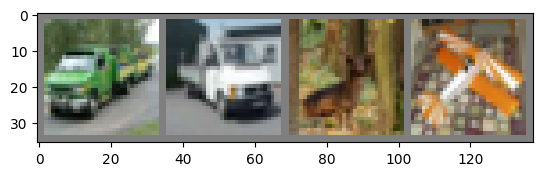

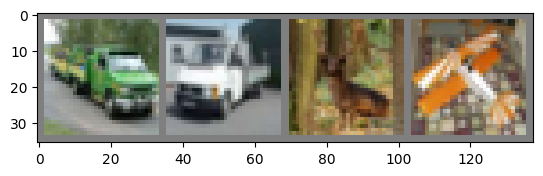

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [14]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4873184279506342, train acc: 0.4688683403911277
 val loss: 1.3018918017123609, val acc: 0.535970744680851

Epoch 1
 train loss: 1.192903588960114, train acc: 0.5807080831126713
 val loss: 1.163650324750454, val acc: 0.5930407801841168

Epoch 2
 train loss: 1.0647084164880964, train acc: 0.6280686864033478
 val loss: 1.0992777875129214, val acc: 0.6207890071767441

Epoch 3
 train loss: 0.999931338718212, train acc: 0.6535159311303272
 val loss: 0.9574359637625673, val acc: 0.6688386526513607

Epoch 4
 train loss: 0.9633317539635262, train acc: 0.6656152063357547
 val loss: 0.9731290233896134, val acc: 0.6610150710065315

Epoch 5
 train loss: 0.9235861546596618, train acc: 0.6785999935331467
 val loss: 0.9376883869475506, val acc: 0.6700576241980207

Epoch 6
 train loss: 0.9061596005664665, train acc: 0.6872796422820641
 val loss: 0.9460969280689321, val acc: 0.6705230497299357

Epoch 7
 tr

Посчитайте точность на тестовой выборке:

In [15]:
test(net, test_loader)

(0.7943684365718987, 0.7300955414012739)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

Добавим больше разнообразия в обучающую выборку, будем с вероятностью 1/2 переворачивать картинку вверх ногами. Это, конечно, только ухудшило положение, потому что на перевернутых картинках сложно распознать объекты, которые не симметричны относительно горизонтали

In [27]:
transform = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6704273592183534, train acc: 0.3943139528225719
 val loss: 1.5354171529729315, val acc: 0.4461214539852548

Epoch 1
 train loss: 1.4060598976869252, train acc: 0.496319208764071
 val loss: 1.3293818580343368, val acc: 0.5180407801841168

Epoch 2
 train loss: 1.2820338489150653, train acc: 0.5473483612376113
 val loss: 1.248794195499826, val acc: 0.5624778369639782

Epoch 3
 train loss: 1.2358855498338313, train acc: 0.5634344803131912
 val loss: 1.2197271466255188, val acc: 0.5738031914893617

Epoch 4
 train loss: 1.1950204493358758, train acc: 0.5798470553902865
 val loss: 1.2000746054852263, val acc: 0.571254432708659

Epoch 5
 train loss: 1.163743776747688, train acc: 0.5862741578213694
 val loss: 1.2035076354412322, val acc: 0.5733820922831272

Epoch 6
 train loss: 1.137611661358333, train acc: 0.5978347806215722
 val loss: 1.1748348436457046, val acc: 0.5833998227373083

Epoch 7
 tra

In [28]:
test(net, test_loader)

(0.9881527017635904, 0.6602308917197452)

Теперь попробуем ColorJitter, который меняет яркость, контраст и насыщенность картинки. Параметры подберем наугад:)

In [30]:
transform = transforms.Compose([
    transforms.ColorJitter(brightness=(0.3, 0.7), contrast=(0.3, 0.7), saturation=(0.3, 0.7)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.770848996024681, train acc: 0.3668549229719521
 val loss: 3.2866781457941583, val acc: 0.23976063829787234

Epoch 1
 train loss: 1.4786086997776624, train acc: 0.4794577566099777
 val loss: 1.9983405919785195, val acc: 0.38018617021276596

Epoch 2
 train loss: 1.3141001133857741, train acc: 0.5411212131571727
 val loss: 1.3403889980721981, val acc: 0.5350620567798614

Epoch 3
 train loss: 1.2397820392735914, train acc: 0.572346728942076
 val loss: 1.3581695008785166, val acc: 0.5365026595744681

Epoch 4
 train loss: 1.1863940082476823, train acc: 0.5872086380255942
 val loss: 1.535473763181808, val acc: 0.4951241135597229

Epoch 5
 train loss: 1.152210958588058, train acc: 0.6024133260114973
 val loss: 1.2922658423159985, val acc: 0.5543882978723405

Epoch 6
 train loss: 1.1188372506519995, train acc: 0.616010218150437
 val loss: 1.4796497273952403, val acc: 0.5083333333756062

Epoch 7
 t

In [31]:
test(net, test_loader)

(2.111784060289905, 0.5633957006369427)

Стало еще хуже, чем раньше, хотя на эту аументацию было больше надежды...

Теперь попробуем RandomResizedCrop - случайное обрезание и изменение размера изображения. Это поможет модели обучаться на различных вариантах ракурсов и масштабов объектов.


In [36]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.8, 0.8)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5773082570576362, train acc: 0.437230673851871
 val loss: 1.3695115393780648, val acc: 0.5118129433469569

Epoch 1
 train loss: 1.3053535734059825, train acc: 0.5392644946928216
 val loss: 1.2542688942970113, val acc: 0.556626773134191

Epoch 2
 train loss: 1.2034637524833192, train acc: 0.5793165644082552
 val loss: 1.1732971363879265, val acc: 0.5914228723404256

Epoch 3
 train loss: 1.1548354039462436, train acc: 0.5965289567244773
 val loss: 1.1133365598130733, val acc: 0.6187943263256803

Epoch 4
 train loss: 1.1144909091579849, train acc: 0.6133496018170874
 val loss: 1.2315484097663392, val acc: 0.5849512412192973

Epoch 5
 train loss: 1.0881190214993968, train acc: 0.6195237007829781
 val loss: 1.1274008266469266, val acc: 0.604720744680851

Epoch 6
 train loss: 1.0716724700857996, train acc: 0.6272076587354461
 val loss: 1.0619520656605985, val acc: 0.6351285461415636

Epoch 7
 t

In [37]:
test(net, test_loader)

(0.9937116682149802, 0.663515127388535)

Тоже повышения качества не обнаружено

Ну на всякий случай запустим все вместе:

In [38]:
transform = transforms.Compose([
    transforms.ColorJitter(brightness=(0.3, 0.7), contrast=(0.3, 0.7), saturation=(0.3, 0.7)),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 0.8)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 2.0043646193073696, train acc: 0.2661758945127728
 val loss: 3.3065397820574174, val acc: 0.20212765957446807

Epoch 1
 train loss: 1.8084774095789824, train acc: 0.338991903953622
 val loss: 1.8932230497928375, val acc: 0.30363475179418603

Epoch 2
 train loss: 1.7232499222868758, train acc: 0.3747796422275808
 val loss: 2.238207918025078, val acc: 0.26584663124794655

Epoch 3
 train loss: 1.655196000278759, train acc: 0.4084413358890596
 val loss: 1.8118533362733558, val acc: 0.3512854610351806

Epoch 4
 train loss: 1.6019882399595633, train acc: 0.4242785322927688
 val loss: 2.4125736246717735, val acc: 0.2778590425531915

Epoch 5
 train loss: 1.5763405088532778, train acc: 0.4347904152909406
 val loss: 1.8863433853108833, val acc: 0.35620567380113805

Epoch 6
 train loss: 1.5482409063597267, train acc: 0.4442862040164048
 val loss: 2.0784747798392114, val acc: 0.34472517738951014

Epoch

In [39]:
test(net, test_loader)

(3.480006811725106, 0.3531050955414013)

Как видим, все совсем плохо. Скорее всего, можно подобрать такую комбинацию и такие параметры, что качество будет лучше, чем в изначальном варианте

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [40]:
import wandb
run = wandb.init(
    project="dl-hw2",
    notes="My first experiment",
    tags=["baseline", "paper1"],
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [41]:
net = BasicBlockNet()
net = net.to(device)

In [42]:
%%wandb
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    loss_function = nn.CrossEntropyLoss()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)

        loss = loss_function(output, target)
        loss_log.append(loss.item())
        
        acc = (output.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    loss_function = nn.CrossEntropyLoss()
    for data, target in train_loader:
        
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        loss_log.append(loss.item())
        
        acc = (output.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item()) 
        
        optimizer.step()
        
    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    train_loss_log_epoch, train_acc_log_epoch = [], []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_loss_log_epoch.append(np.mean(train_loss))
        train_acc_log_epoch.append(np.mean(train_acc))


        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        f, ax = plot_loss_acc(train_loss_log, train_acc_log, val_loss_log, val_acc_log)
        wandb.log({"Loss": ax[1]})
        wandb.log({'Accuracy':ax[0]})  

        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [43]:

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 2.0261559290249562, train acc: 0.2524320971922203
 val loss: 2.0003863755692826, val acc: 0.28424202127659576



/opt/conda/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Epoch 1
 train loss: 1.80959194081357, train acc: 0.33804110084852745
 val loss: 1.9446641013977375, val acc: 0.3305186170212766

Epoch 2
 train loss: 1.7257473760810587, train acc: 0.37113149652097516
 val loss: 1.8664094189380078, val acc: 0.3058510638297872

Epoch 3
 train loss: 1.6770718415868784, train acc: 0.3933835531937357
 val loss: 2.221535016628022, val acc: 0.3032358156239733

Epoch 4
 train loss: 1.6275408422707203, train acc: 0.41321575478182415
 val loss: 1.8019994791517866, val acc: 0.37016843988540327

Epoch 5
 train loss: 1.5903767347335815, train acc: 0.4304485505743044
 val loss: 2.1201956003270253, val acc: 0.3300310284533399

Epoch 6
 train loss: 1.562415141946001, train acc: 0.4390261818329638
 val loss: 1.6227208167948621, val acc: 0.4219414893617021

Epoch 7
 train loss: 1.5335713101915294, train acc: 0.4517498041419704
 val loss: 3.2295345194796297, val acc: 0.273359929120287

Epoch 8
 train loss: 1.5064199310769983, train acc: 0.45971533040459894
 val loss: 1

In [44]:
test(net, test_loader)

(2.9324294829824167, 0.39828821656050956)

In [45]:
run.finish()